In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import glob
train_paths = glob.glob('data/train/**/**')
val_paths = glob.glob('data/val/**/**')
test_paths = glob.glob('data/test/**')
print(len(train_paths),len(val_paths),len(test_paths))

53723 5967 14927


In [3]:
labels_dict = {'venomous':1,'non_venomous':0}
labels_dict_rev = {1:'venomous',0:'non_venomous'}
labels_dict,labels_dict_rev

({'venomous': 1, 'non_venomous': 0}, {1: 'venomous', 0: 'non_venomous'})

In [4]:
train_df = pd.DataFrame(train_paths,columns=['path'])
train_df['class'] = train_df['path'].apply(lambda x:x.split('/')[2])
train_df['label'] = train_df['class'].apply(lambda x:labels_dict[x])


val_df = pd.DataFrame(val_paths,columns=['path'])
val_df['class'] = val_df['path'].apply(lambda x:x.split('/')[2])
val_df['label'] = val_df['class'].apply(lambda x:labels_dict[x])


test_df = pd.DataFrame(test_paths,columns=['path'])
# test_df['class'] = test_df['path'].apply(lambda x:x.split('/')[2])
print(train_df.shape,val_df.shape,test_df.shape)

(53723, 3) (5967, 3) (14927, 1)


In [5]:
train_df.sample(10)

,path,class,label
17560,data/train/venomous/7aded18b34fe5b14c503387245...,venomous,1
48722,data/train/non_venomous/7e629972ee7abe91c70dd4...,non_venomous,0
5495,data/train/venomous/9a7a9964b1083fb37f56cf06b6...,venomous,1
47533,data/train/non_venomous/2df8a90a4f042b91cf0dd5...,non_venomous,0
10303,data/train/venomous/e5b47496e084a802f0ed0444df...,venomous,1
44514,data/train/non_venomous/9852b27d2d7cd1136b082c...,non_venomous,0
8950,data/train/venomous/606e070c80d5e99a885233126c...,venomous,1
42285,data/train/non_venomous/1a142d0d41eb3bd29b6969...,non_venomous,0
6018,data/train/venomous/552564baf9c06b91ecf0a16f48...,venomous,1
48602,data/train/non_venomous/6c3cd88755e1d06aa12517...,non_venomous,0


In [6]:
from albumentations import (
    Compose, HorizontalFlip, ShiftScaleRotate,GaussNoise,Flip,RandomRotate90,RandomSizedCrop,RandomBrightnessContrast,Cutout,
)
import cv2

In [7]:
AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.85),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1,
                     rotate_limit=25, border_mode=cv2.BORDER_REFLECT_101, p=0.8),
    Flip(),
    RandomRotate90(),
    RandomSizedCrop((200 - 50, 180 + 25), 224, 224),
#     RandomBrightnessContrast(brightness_limit= 0.4,contrast_limit=0.4,brightness_by_max=False),
    Cutout()
    ])

In [8]:

import keras
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
class DataGenerator(keras.utils.Sequence):
  def __init__(self, list_IDs, labels, augmentation,dim,batch_size=32, n_channels=3,
             n_classes=101, shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()
    self.augment = augmentation
    self.index = 0

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    self.index = 0
    if self.shuffle == True:
        np.random.shuffle(self.indexes)
  def __data_generation(self, list_IDs_temp,labels):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = []#np.empty((self.batch_size, *self.dim, self.n_channels))
    y = []

    # Generate data
    bbs = 0
    for ID ,lab in zip(list_IDs_temp,labels):
        # Store sample
        try:
            xx = cv2.imread(ID)
            xx = cv2.resize(xx, self.dim)
        except:
            continue
#         xx = cv2.imread(ID)
#         #print(ID)
#         xx = cv2.resize(xx, (256,256))
        xx = cv2.cvtColor(xx, cv2.COLOR_BGR2RGB)
        xx = xx/255.

        X.append(xx)
        
        # Store class
        y.append(lab)
        
        bbs = bbs+1
        
        if bbs == self.batch_size:
          break
    self.index+=1
    return np.stack([self.augment(image=x)["image"] for x in X], axis=0),(y)
  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[self.index*self.batch_size:(self.index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp,lab = [self.list_IDs[k] for k in indexes],[self.labels[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp,lab)
    #X = np.expand_dims(X,axis=0)

    return X, np.array(y)

Using TensorFlow backend.


In [9]:
params = {'dim': (224,224),
          'batch_size': 32,
          'n_classes': 1,
          'n_channels': 3,
          'shuffle': True,
          'augmentation': AUGMENTATIONS_TRAIN
          }

training_generator = DataGenerator(train_df.path.values,train_df['label'].values , **params)

In [14]:
x,y = next(iter(training_generator))

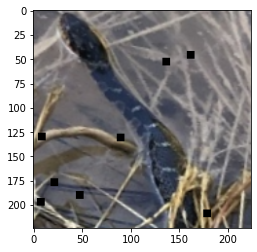

In [17]:
plt.imshow(x[2])

In [18]:
y

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [19]:
class DataGeneratorwithoutaug(keras.utils.Sequence):
  def __init__(self, list_IDs, labels,batch_size=32, dim=(256,256), n_channels=3,
             n_classes=101, shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()
    self.index = 0
    

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    self.index = 0
    if self.shuffle == True:
        np.random.shuffle(self.indexes)
  def __data_generation(self, list_IDs_temp,labels):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = []#np.empty((self.batch_size, *self.dim, self.n_channels))
    y = []

    # Generate data
    bbs = 0
    for ID ,lab in zip(list_IDs_temp,labels):
        # Store sample
        # print(ID)
        try:
            xx = cv2.imread(ID)
            xx = cv2.resize(xx, self.dim)
        except:
            continue
        #print(ID)
        
        xx = cv2.cvtColor(xx, cv2.COLOR_BGR2RGB)
        xx = xx/255.

        X.append(xx)
        
        # Store class
        y.append(lab)
        
        bbs = bbs+1
        if bbs == self.batch_size:
          break
    self.index+=1
    return np.array(X),y
  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch

    indexes = self.indexes[self.index*self.batch_size:(self.index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp,lab = [self.list_IDs[k] for k in indexes],[self.labels[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp,lab)
    #X = np.expand_dims(X,axis=0)

    return X, np.array(y)

In [20]:
params = {'dim': (224,224),
          # 'batch_size': 29,#len(y_val),
          'n_classes': 1,
          'n_channels': 3,
          'shuffle': False,
          #'augmentation': AUGMENTATIONS_TRAIN
          }
val_all = DataGeneratorwithoutaug(val_df.path.values,val_df['label'].values,batch_size=val_df.shape[0],**params)

In [21]:
X_val,y_val = next(iter(val_all))

In [22]:
X_val.shape,y_val.shape

((5967, 224, 224, 3), (5967,))

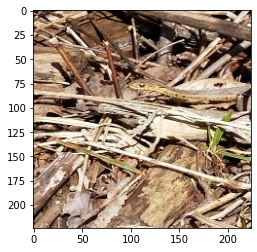

In [23]:
plt.imshow(X_val[0])

## Modeling


In [24]:
import efficientnet.keras as efn 
base = efn.EfficientNetB0(include_top = False,input_shape=(224,224,3),weights='imagenet')
# base.summary()
len(base.layers)

230

In [25]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout,Input,GlobalAveragePooling2D,Activation,BatchNormalization,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers import Input,Dense,Activation,Flatten,GlobalAveragePooling2D,Dropout
from keras.layers import LeakyReLU
#model.trainable = False
from keras import backend as K
from keras import optimizers as op

In [26]:
x = base.output
# x = Conv2D(64,(5,5),padding = "same")(x)
# x = Activation("relu")(x)
# x = MaxPooling2D((2,2))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.25)(x)
# x = Conv2D(128,(3,3),padding = "same")(x)
# x = Activation("relu")(x)
# x = MaxPooling2D((2,2))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.25)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(rate = 0.4)(x)

x = Dense(512,kernel_initializer='he_normal',)(x)
x = LeakyReLU(0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(512,kernel_initializer='he_normal',)(x)
x = LeakyReLU(0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
# x = Dense(256)(x)
# x = BatchNormalization()(x)
# x = LeakyReLU(0.1)(x)
# x = Dropout(0.5)(x)
predictions = Dense(1,kernel_initializer='he_normal', #kernel_regularizer=l2(.0005), 
                    activation= 'sigmoid')(x)
model = Model(inputs = base.input, outputs = predictions)


In [21]:
for l in base.layers[:175]:
  l.trainable = False


In [22]:
model.compile(op.Adam(lr = 1e-3), loss = "binary_crossentropy", metrics = ["accuracy"])

In [23]:
hist2 = model.fit_generator(generator=training_generator,epochs =10,steps_per_epoch= training_generator.__len__(),
                        verbose =1,
                    validation_data=(X_val,y_val),#,validation_steps = validation_generator.__len__(),
                    use_multiprocessing=True,
                    workers=8,)

Epoch 1/10
1678/1678 [==============================] - 308s 184ms/step - loss: 0.5690 - accuracy: 0.7206 - val_loss: 0.6727 - val_accuracy: 0.6566
Epoch 2/10
1678/1678 [==============================] - 255s 152ms/step - loss: 0.5278 - accuracy: 0.7426 - val_loss: 0.8844 - val_accuracy: 0.6114
Epoch 3/10
1678/1678 [==============================] - 256s 153ms/step - loss: 0.4982 - accuracy: 0.7574 - val_loss: 1.2223 - val_accuracy: 0.5693
Epoch 4/10
1678/1678 [==============================] - 254s 152ms/step - loss: 0.4791 - accuracy: 0.7689 - val_loss: 0.5874 - val_accuracy: 0.7099
Epoch 5/10
1678/1678 [==============================] - 255s 152ms/step - loss: 0.4798 - accuracy: 0.7635 - val_loss: 1.0175 - val_accuracy: 0.6013
Epoch 6/10
1678/1678 [==============================] - 256s 152ms/step - loss: 0.4567 - accuracy: 0.7833 - val_loss: 0.7284 - val_accuracy: 0.6461
Epoch 7/10
1678/1678 [==============================] - 257s 153ms/step - loss: 0.4476 - accuracy: 0.7876 - val_

In [39]:
model.load_weights('10.h5')

In [27]:
from keras.callbacks.callbacks import ReduceLROnPlateau

for l in base.layers:
  l.trainable = True
# for l in base.layers[:100]:
#   l.trainable = False
cr = ReduceLROnPlateau(monitor='val_loss',factor = 0.9,patience = 5,verbose=1)

model.compile(op.Adam(lr = 1e-4), loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
hist2 = model.fit_generator(generator=training_generator,epochs =11,steps_per_epoch= training_generator.__len__(),
                        verbose =1,
                        validation_data = (X_val,y_val),
#                     validation_data=validation_generator,validation_steps = validation_generator.__len__(),
                    use_multiprocessing=True,
                    workers=8,callbacks=[cr])

Epoch 1/11
1678/1678 [==============================] - 843s 502ms/step - loss: 0.4007 - accuracy: 0.8132 - val_loss: 0.4849 - val_accuracy: 0.7667
Epoch 2/11
1678/1678 [==============================] - 814s 485ms/step - loss: 0.3786 - accuracy: 0.8241 - val_loss: 0.4234 - val_accuracy: 0.7934
Epoch 3/11
1678/1678 [==============================] - 812s 484ms/step - loss: 0.3485 - accuracy: 0.8431 - val_loss: 0.4029 - val_accuracy: 0.8145
Epoch 5/11
1678/1678 [==============================] - 812s 484ms/step - loss: 0.3390 - accuracy: 0.8465 - val_loss: 0.4285 - val_accuracy: 0.7964
Epoch 6/11
1678/1678 [==============================] - 812s 484ms/step - loss: 0.3290 - accuracy: 0.8514 - val_loss: 0.4134 - val_accuracy: 0.8046
Epoch 7/11
1678/1678 [==============================] - 813s 484ms/step - loss: 0.3168 - accuracy: 0.8591 - val_loss: 0.3665 - val_accuracy: 0.8321
Epoch 8/11
 476/1678 [=======>......................] - ETA: 9:28 - loss: 0.3193 - accuracy: 0.8560

In [24]:
model.evaluate(X_val,y_val,verbose=1)

5967/5967 [==============================] - 25s 4ms/step


[0.41487119204513145, 0.8112954497337341]

In [21]:
model.load_weights('21.h5')

In [23]:
model.compile(op.Adam(lr = 7e-5), loss = "binary_crossentropy", metrics = ["accuracy"])
hist2 = model.fit_generator(generator=training_generator,epochs =17,steps_per_epoch= training_generator.__len__(),
                        verbose =1,
                        validation_data = (X_val,y_val),
#                     validation_data=validation_generator,validation_steps = validation_generator.__len__(),
                    use_multiprocessing=True,
                    workers=8,callbacks=[cr])

In [23]:
# from keras.models import load_model
# model = load_model('ch_1.h5')

In [ ]:
model.compile(op.Adam(lr = 7e-5), loss = "binary_crossentropy", metrics = ["accuracy"])
hist2 = model.fit_generator(generator=training_generator,epochs =25,steps_per_epoch= training_generator.__len__(),
                        verbose =1,
                        validation_data = (X_val,y_val),
#                     validation_data=validation_generator,validation_steps = validation_generator.__len__(),
                    use_multiprocessing=True,
                    workers=8,callbacks=[cr])

Epoch 1/25
1678/1678 [==============================] - 836s 498ms/step - loss: 0.2795 - accuracy: 0.8779 - val_loss: 0.3934 - val_accuracy: 0.8202
Epoch 2/25
1678/1678 [==============================] - 811s 484ms/step - loss: 0.2756 - accuracy: 0.8783 - val_loss: 0.4284 - val_accuracy: 0.8036
Epoch 3/25
1678/1678 [==============================] - 811s 483ms/step - loss: 0.2676 - accuracy: 0.8843 - val_loss: 0.3704 - val_accuracy: 0.8309
Epoch 4/25
1678/1678 [==============================] - 812s 484ms/step - loss: 0.2644 - accuracy: 0.8864 - val_loss: 0.3558 - val_accuracy: 0.8366
Epoch 5/25
1678/1678 [==============================] - 812s 484ms/step - loss: 0.2601 - accuracy: 0.8900 - val_loss: 0.3347 - val_accuracy: 0.8473
Epoch 6/25
1678/1678 [==============================] - 811s 484ms/step - loss: 0.2476 - accuracy: 0.8955 - val_loss: 0.3511 - val_accuracy: 0.8410
Epoch 7/25
1678/1678 [==============================] - 814s 485ms/step - loss: 0.2506 - accuracy: 0.8922 - val_

In [28]:
model.evaluate(X_val,y_val,verbose=1)

5967/5967 [==============================] - 22s 4ms/step


[0.3439080384476427, 0.8493380546569824]

In [29]:
model.compile(op.Adam(lr = 5e-5), loss = "binary_crossentropy", metrics = ["accuracy"])
hist2 = model.fit_generator(generator=training_generator,epochs =3,steps_per_epoch= training_generator.__len__(),
                        verbose =1,
                        validation_data = (X_val,y_val),
#                     validation_data=validation_generator,validation_steps = validation_generator.__len__(),
                    use_multiprocessing=True,
                    workers=8,callbacks=[cr])

Epoch 1/3
1678/1678 [==============================] - 855s 509ms/step - loss: 0.1871 - accuracy: 0.9237 - val_loss: 0.3514 - val_accuracy: 0.8460
Epoch 2/3
1678/1678 [==============================] - 813s 484ms/step - loss: 0.2144 - accuracy: 0.9094 - val_loss: 0.3480 - val_accuracy: 0.8488
Epoch 3/3
1678/1678 [==============================] - 816s 486ms/step - loss: 0.2104 - accuracy: 0.9129 - val_loss: 0.3373 - val_accuracy: 0.8554


In [49]:
model.evaluate(X_val,y_val,verbose=1)

5967/5967 [==============================] - 25s 4ms/step


[0.3372694015295657, 0.8553712368011475]

In [28]:
model.load_weights("35.h5")

In [32]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint("best.h5",verbose=1, save_best_only=True)

In [35]:
model.compile(op.Adam(lr = 1e-5), loss = "binary_crossentropy", metrics = ["accuracy"])
hist2 = model.fit_generator(generator=training_generator,epochs =10,steps_per_epoch= training_generator.__len__(),
                        verbose =1,
                        validation_data = (X_val,y_val),
#                     validation_data=validation_generator,validation_steps = validation_generator.__len__(),
                    use_multiprocessing=True,
                    workers=8,callbacks=[cr,mc])

Epoch 1/10
1678/1678 [==============================] - 855s 509ms/step - loss: 0.2065 - accuracy: 0.9140 - val_loss: 0.3335 - val_accuracy: 0.8567

Epoch 00001: val_loss improved from inf to 0.33351, saving model to best.h5
Epoch 2/10
1678/1678 [==============================] - 820s 489ms/step - loss: 0.2112 - accuracy: 0.9112 - val_loss: 0.3369 - val_accuracy: 0.8607

Epoch 00002: val_loss did not improve from 0.33351
Epoch 3/10
1678/1678 [==============================] - 819s 488ms/step - loss: 0.2003 - accuracy: 0.9161 - val_loss: 0.3290 - val_accuracy: 0.8599

Epoch 00003: val_loss improved from 0.33351 to 0.32901, saving model to best.h5
Epoch 4/10
1678/1678 [==============================] - 819s 488ms/step - loss: 0.2001 - accuracy: 0.9179 - val_loss: 0.3346 - val_accuracy: 0.8579

Epoch 00004: val_loss did not improve from 0.32901
Epoch 5/10
1678/1678 [==============================] - 819s 488ms/step - loss: 0.1927 - accuracy: 0.9195 - val_loss: 0.3430 - val_accuracy: 0.855

In [28]:
model.load_weights("45.h5")

In [59]:
# model.compile(op.Adam(lr = 1e-5), loss = "binary_crossentropy", metrics = ["accuracy"])

model.evaluate(X_val,y_val,verbose=1)

5967/5967 [==============================] - 22s 4ms/step


[0.317563035209634, 0.8649237751960754]

In [55]:
model.compile(op.Adam(lr = 5e-6), loss = "binary_crossentropy", metrics = ["accuracy"])
hist2 = model.fit_generator(generator=training_generator,epochs =10,steps_per_epoch= training_generator.__len__(),
                        verbose =1,
                        validation_data = (X_val,y_val),
#                     validation_data=validation_generator,validation_steps = validation_generator.__len__(),
                    use_multiprocessing=True,
                    workers=8,callbacks=[cr,mc])

Epoch 1/10
1678/1678 [==============================] - 844s 503ms/step - loss: 0.1886 - accuracy: 0.9221 - val_loss: 0.3254 - val_accuracy: 0.8634

Epoch 00001: val_loss did not improve from 0.31756
Epoch 2/10
1678/1678 [==============================] - 812s 484ms/step - loss: 0.1898 - accuracy: 0.9225 - val_loss: 0.3258 - val_accuracy: 0.8616

Epoch 00002: val_loss did not improve from 0.31756
Epoch 3/10
1678/1678 [==============================] - 807s 481ms/step - loss: 0.1815 - accuracy: 0.9246 - val_loss: 0.3237 - val_accuracy: 0.8634

Epoch 00003: val_loss did not improve from 0.31756
Epoch 4/10
1678/1678 [==============================] - 812s 484ms/step - loss: 0.1842 - accuracy: 0.9241 - val_loss: 0.3278 - val_accuracy: 0.8619

Epoch 00004: val_loss did not improve from 0.31756
Epoch 5/10
1678/1678 [==============================] - 811s 484ms/step - loss: 0.1818 - accuracy: 0.9260 - val_loss: 0.3280 - val_accuracy: 0.8584

Epoch 00005: val_loss did not improve from 0.31756


In [56]:
model.evaluate(X_val,y_val,verbose=1)

5967/5967 [==============================] - 22s 4ms/step


[0.32678796418288386, 0.8627451062202454]

In [ ]:
#Using "45.h5" for predicting test dataset

## Test


In [29]:
sub = pd.read_csv('sample_submission.csv')

In [30]:
sub['path'] = 'data/test/'+sub['id']+".jpg"
sub.head()

,id,class,path
0,00022e97c90898c02a25579be,venomous,data/test/00022e97c90898c02a25579be.jpg
1,000816b96db153cc47dfb79db,venomous,data/test/000816b96db153cc47dfb79db.jpg
2,001d2fe5ca243c138472d130b,venomous,data/test/001d2fe5ca243c138472d130b.jpg
3,001e3329abba16fb91ee4d47f,venomous,data/test/001e3329abba16fb91ee4d47f.jpg
4,0026cf1ed9556341340419b19,venomous,data/test/0026cf1ed9556341340419b19.jpg


In [31]:
class TestDataGenerator(keras.utils.Sequence):
  def __init__(self, list_IDs, augmentation,batch_size=32, dim=(256,256), n_channels=3,
             n_classes=101, shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
#     self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()
    self.augment = augmentation

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
        np.random.shuffle(self.indexes)
  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = []#np.empty((self.batch_size, *self.dim, self.n_channels))
    

    # Generate data
    bbs = 0
    for ID  in (list_IDs_temp):
        # Store sample
        xx = cv2.imread(ID)
        #print(ID)
        xx = cv2.resize(xx,self.dim)
        xx = cv2.cvtColor(xx, cv2.COLOR_BGR2RGB)
        xx = xx/255.

        X.append(xx)
        
        # Store class
        
        
        bbs = bbs+1
        if bbs == self.batch_size:
          break
    return np.stack([self.augment(image=x)["image"] for x in X], axis=0)
  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X= self.__data_generation(list_IDs_temp)
    #X = np.expand_dims(X,axis=0)

    return X

In [32]:
class TestDataGeneratorwithoutaug(keras.utils.Sequence):
  def __init__(self, list_IDs,batch_size, dim=(256,256), n_channels=3,
             n_classes=101, shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    #self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()
    

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs),)
    if self.shuffle == True:
        np.random.shuffle(self.indexes)
  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = []#np.empty((self.batch_size, *self.dim, self.n_channels))
    

    # Generate data
    bbs = 0
    for ID  in (list_IDs_temp):
        # Store sample
        xx = cv2.imread(ID)
        #print(ID)
        xx = cv2.resize(xx, self.dim)
        xx = cv2.cvtColor(xx, cv2.COLOR_BGR2RGB)
        xx = xx/255.

        X.append(xx)
        
        # Store class
        
        
        bbs = bbs+1
        if bbs == self.batch_size:
          break
    return np.array(X)
  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    # Generate data
    X= self.__data_generation(list_IDs_temp)
    #X = np.expand_dims(X,axis=0)

    return X

In [33]:
# AUGMENTATIONS_TEST = Compose([
#     HorizontalFlip(p=0.5),
#     ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1,
#                      rotate_limit=25, border_mode=cv2.BORDER_REFLECT_101, p=0.9),
#     Flip(),
#     RandomRotate90(p=-0.25),
#     RandomSizedCrop((200 - 50, 220 + 25), 256, 256,p=0.25),
# #     RandomBrightnessContrast(brightness_limit= 0.4,contrast_limit=0.4,p=0.25),
#     Cutout()
#     ])



AUGMENTATIONS_TEST = Compose([
    HorizontalFlip(p=0.85),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1,
                     rotate_limit=25, border_mode=cv2.BORDER_REFLECT_101, p=0.8),
    Flip(),
    RandomRotate90(),
    RandomSizedCrop((200 - 50, 180 + 25), 224, 224),
#     RandomBrightnessContrast(brightness_limit= 0.4,contrast_limit=0.4,brightness_by_max=False),
    Cutout()
    ])

In [34]:
vparams = {'dim': (224,224),
          'batch_size': 59,#len(test_fnames),
          'n_classes': 1,
          'n_channels': 3,
          'shuffle': False,
          'augmentation': AUGMENTATIONS_TEST
          }

testaug = TestDataGenerator(sub['path'],**vparams)

In [35]:
c = next(iter(testaug))

In [36]:
c.shape

(59, 224, 224, 3)

In [37]:
tp = {'dim': (224,224),
          'batch_size': 59,
          'n_classes': 1,
          'n_channels': 3,
          'shuffle': False,
          #'augmentation': AUGMENTATIONS_TRAIN
          }


test_generator = TestDataGeneratorwithoutaug(sub['path'],**tp)

In [47]:
pred = model.predict_generator(test_generator,steps = test_generator.__len__(),verbose=1)


253/253 [==============================] - 85s 337ms/step


In [50]:
make_sub(pred,'e45.csv')

                          id         class
0  00022e97c90898c02a25579be  non_venomous
1  000816b96db153cc47dfb79db      venomous
2  001d2fe5ca243c138472d130b      venomous
3  001e3329abba16fb91ee4d47f  non_venomous
4  0026cf1ed9556341340419b19      venomous


In [39]:
p = np.zeros((14927,))
for i in range(25):
    pred = model.predict_generator(testaug,steps = testaug.__len__(),verbose=1)
    p+= pred.reshape(-1)
    print(i,'--')

253/253 [==============================] - 114s 451ms/step
0 --
253/253 [==============================] - 83s 329ms/step
1 --
253/253 [==============================] - 74s 294ms/step
2 --
253/253 [==============================] - 80s 315ms/step
3 --
253/253 [==============================] - 77s 306ms/step
4 --
253/253 [==============================] - 72s 285ms/step
5 --
253/253 [==============================] - 69s 271ms/step
6 --
253/253 [==============================] - 69s 274ms/step
7 --
253/253 [==============================] - 68s 270ms/step
9 --
253/253 [==============================] - 68s 269ms/step
10 --
253/253 [==============================] - 76s 302ms/step
11 --
253/253 [==============================] - 70s 278ms/step
12 --
253/253 [==============================] - 70s 275ms/step
13 --
253/253 [==============================] - 78s 310ms/step
14 --
253/253 [==============================] - 73s 289ms/step
15 --
253/253 [==============================] - 70s 2

In [40]:
fpp = p/25
fp = (fpp>0.5).astype('int32')

fp.shape

(14927,)

In [41]:
fp

array([0, 0, 1, ..., 0, 0, 0], dtype=int32)

In [42]:
make_sub(fp,"e45_tta_25.csv")

                          id         class
0  00022e97c90898c02a25579be  non_venomous
1  000816b96db153cc47dfb79db  non_venomous
2  001d2fe5ca243c138472d130b      venomous
3  001e3329abba16fb91ee4d47f  non_venomous
4  0026cf1ed9556341340419b19      venomous


In [38]:
def make_sub(pred,name):
    fp = (pred >0.5).astype('int32')
    sub['class'] = fp
    sub['class'] = sub['class'].apply(lambda x: labels_dict_rev[x])
    final = sub[['id','class']]
    print(final.head())
    final.to_csv(name,index = False)